In [4]:
import wfcommons.wfchef.utils as utils

from QHyper.problems.algorithms.utils import wfworkflow_to_qhyper_workflow, merge_subworkflows, draw
from QHyper.problems.algorithms.workflow_decomposition import HeftBasedAlgorithm, preprocess_workflow
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingProblem, WorkflowSchedulingOneHot, WorkflowSchedulingBinary
from QHyper.solvers.gurobi import Gurobi

## Load and divide workflow

In [16]:
tasks_file = "workflows_data/workflows/complex_workflow.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

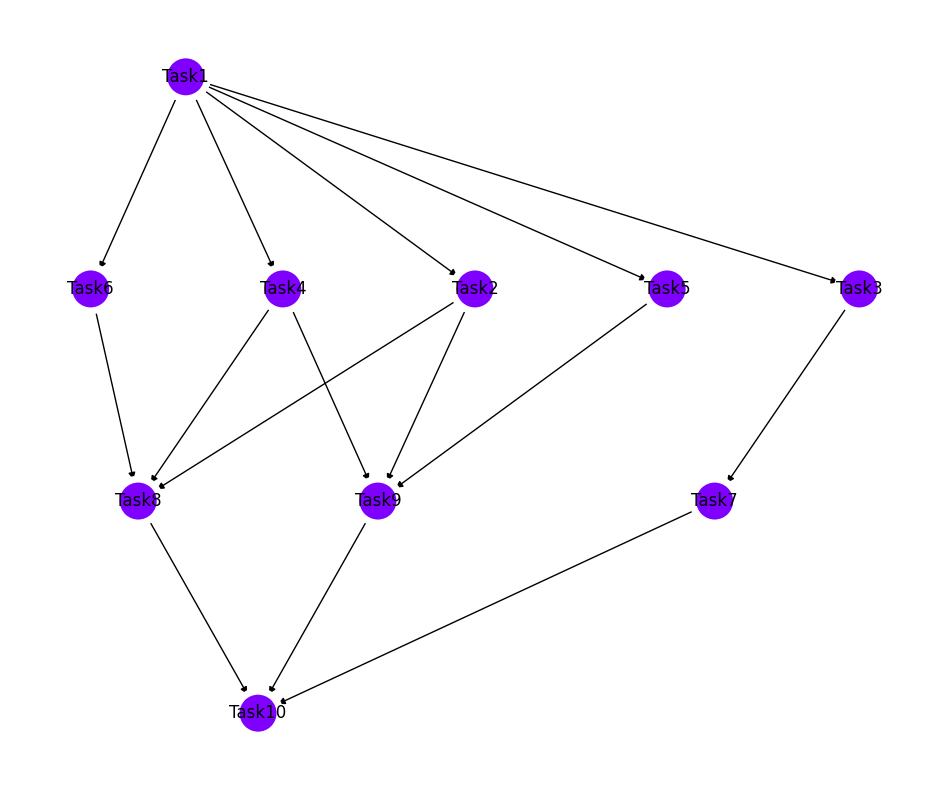

In [17]:
workflow = Workflow(tasks_file, machines_file, deadline)
utils.draw(workflow.wf_instance.workflow, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

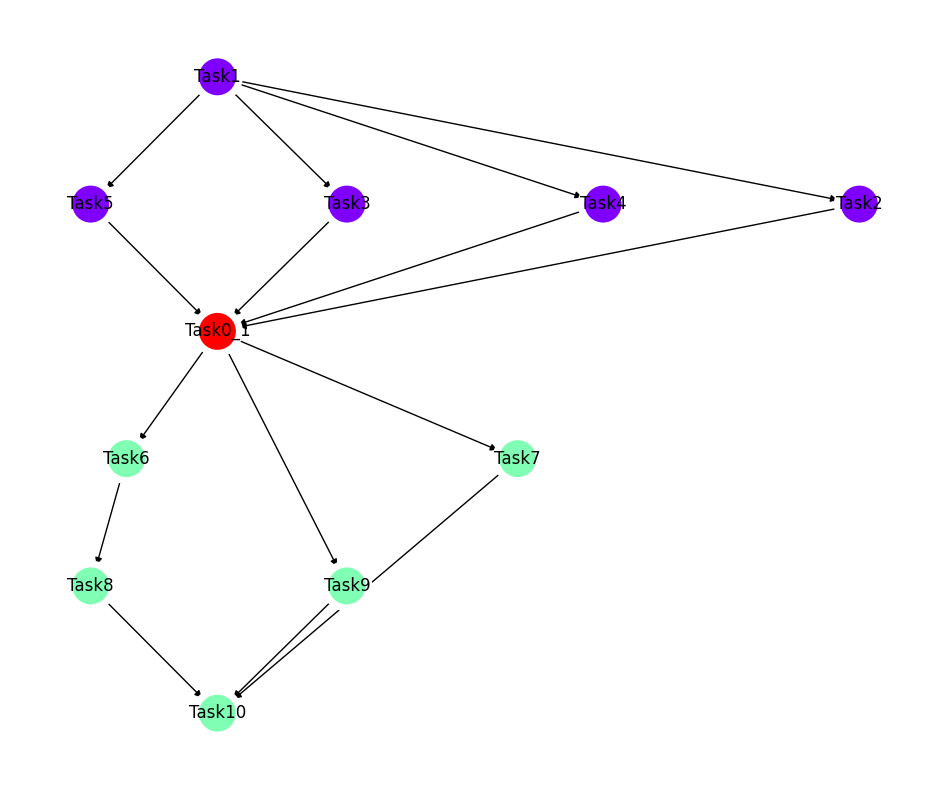

In [18]:
subworkflows, deadlines = HeftBasedAlgorithm().decompose(workflow, 2)
wf_workflow1, wf_workflow2 = subworkflows
deadline1, deadline2 = deadlines
merged = merge_subworkflows([wf_workflow1, wf_workflow2])
utils.draw(merged, with_labels=True)

In [19]:
# For unknown reason Gurobi fails to solve WSP when deadline is not an integer
deadline1, deadline2 = round(deadline1), round(deadline2)

In [20]:
workflow1 = wfworkflow_to_qhyper_workflow(wf_workflow1, machines_file, deadline1)
workflow2 = wfworkflow_to_qhyper_workflow(wf_workflow2, machines_file, deadline2)
wsp1 = WorkflowSchedulingProblem(workflow1)
wsp2 = WorkflowSchedulingProblem(workflow2)

## Solve the Workflow Schedluling Problem with the Gurobi solver.

In [23]:
gurobi1 = Gurobi(problem=wsp1)
gurobi2 = Gurobi(problem=wsp2)

solution_gurobi1 = gurobi1.solve(params_inits={"name": "wsp1"})
solution_gurobi2 = gurobi2.solve(params_inits={"name": "wsp2"})

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 23 columns and 62 nonzeros
Model fingerprint: 0xcb76fd61
Variable types: 0 continuous, 23 integer (23 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 10 rows and 23 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 27 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+01, best bound 2.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.8

In [24]:
solution1 = wsp1.decode_solution(solution_gurobi1)
# solution1 = {'Task1': 'MachineA', 'Task2': 'MachineB', 'Task6': 'MachineA', 'Task4': 'MachineA', 'Task5': 'MachineA', 'Task0_1': 'MachineA'}
solution2 = wsp2.decode_solution(solution_gurobi2)
# solution2 = {'Task3': 'MachineB', 'Task9': 'MachineB', 'Task8': 'MachineA', 'Task7': 'MachineB', 'Task10': 'MachineA', 'Task0_1': 'MachineA'}

print(f"Task assignment for first subgraph: {solution1}")
print(f"Task assignment for second subgraph: {solution2}")

Task assignment for first subgraph: {'Task1': 'MachineA', 'Task4': 'MachineB', 'Task5': 'MachineA', 'Task3': 'MachineA', 'Task2': 'MachineA', 'Task0_1': 'MachineA'}
Task assignment for second subgraph: {'Task6': 'MachineB', 'Task8': 'MachineB', 'Task9': 'MachineA', 'Task7': 'MachineA', 'Task10': 'MachineA', 'Task0_1': 'MachineA'}


In [25]:
cost1 = wsp1.calculate_solution_cost(solution1)
time1 = wsp1.calculate_solution_timespan(solution1)
print(f"Cost of running first subworkflow: {cost1}")
print(f"Time of running first subworkflow: {time1}")

cost2 = wsp2.calculate_solution_cost(solution2)
time2 = wsp2.calculate_solution_timespan(solution2)
print(f"Cost of running second subworkflow: {cost2}")
print(f"Time of running second subworkflow: {time2}")

print(f"Cost of running full workflow: {cost1 + cost2}")
print(f"Time of running full workflow: {time1 + time2}")

Cost of running first subworkflow: 29.0
Time of running first subworkflow: 9.0
Cost of running second subworkflow: 50.0
Time of running second subworkflow: 21.0
Cost of running full workflow: 79.0
Time of running full workflow: 30.0


## Version without split on Gurobi

In [10]:
wsp = WorkflowSchedulingProblem(workflow)
gurobi = Gurobi(problem=wsp)
solution_gurobi = gurobi.solve(params_inits = {"name": "wsp"})

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 36 columns and 156 nonzeros
Model fingerprint: 0xcb15527a
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 1 rows and 16 columns
Presolve time: 0.00s
Presolved: 16 rows, 20 columns, 74 nonzeros
Variable types: 0 continuous, 20 integer (19 binary)
Found heuristic solution: objective 72.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 72 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.200000000000e+01, best bound 7.200000000000e+01, gap 0.0000%


In [11]:
solution = wsp.decode_solution(solution_gurobi)
print(f"Task assignment for full graph: {solution}")

Task assignment for full graph: {'Task1': 'MachineB', 'Task2': 'MachineC', 'Task3': 'MachineA', 'Task4': 'MachineA', 'Task5': 'MachineA', 'Task6': 'MachineA', 'Task7': 'MachineA', 'Task8': 'MachineA', 'Task9': 'MachineA', 'Task10': 'MachineA'}


In [12]:
cost = wsp.calculate_solution_cost(solution)
time = wsp.calculate_solution_timespan(solution)
print(f"Cost of running full workflow: {cost}")
print(f"Time of running full workflow: {time}")

Cost of running full workflow: 75.0
Time of running full workflow: 28.0


## Save results as reports

In [2]:
from reports.report import ExecutionReport, Division, Subworkflow, Solution, WorkflowSolution

In [27]:
with_division_report = ExecutionReport(
    workflow=tasks_file,
    machines=machines_file,
    deadline=deadline,
    division=Division(
        method="HeftBasedAlgorithm",
        workflows=[
            Subworkflow(id=0,deadline=workflow1.deadline,workflow=workflow1),
            Subworkflow(id=1,deadline=workflow2.deadline,workflow=workflow2)
        ]
    ),
    solution=Solution(
        solver="Gurobi",
        workflows=[
            WorkflowSolution(id=0,machine_assignment=solution1,cost=cost1,time=time1),
            WorkflowSolution(id=1,machine_assignment=solution2,cost=cost2,time=time2)
        ],
        cost=cost1+cost2,
        time=time1+time2
    )
)

In [28]:
with_division_report.write_json("reports/gurobi_division_v2_02_18_24.json")

In [16]:
without_division_report = ExecutionReport(
    workflow=tasks_file,
    machines=machines_file,
    deadline=deadline,
    division=Division(
        method="HeftBasedAlgorithm",
        workflows=[
            Subworkflow(id=0,deadline=workflow.deadline,workflow=workflow)
        ]
    ),
    solution=Solution(
        solver="Gurobi",
        workflows=[
            WorkflowSolution(id=0,machine_assignment=solution,cost=cost,time=time)
        ],
        cost=cost,
        time=time
    )
)

In [17]:
without_division_report.write_json("reports/gurobi_no_division_02_18_24.json")

# Divide real life workflow

## No division

In [21]:
# tasks_file = "workflows_data/workflows/complex_workflow.json"
tasks_file = "workflows_data/workflows/srasearch_22_tasks.json"
machines_file = "workflows_data/machines/cyfronet.json"
deadline = 5000
workflow_genome = Workflow(tasks_file, machines_file, deadline)
wsp = WorkflowSchedulingOneHot(workflow_genome)

gurobi = Gurobi(problem=wsp)
solution_gurobi = gurobi.solve(params_inits = {"name": "wsp"})

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42 rows, 110 columns and 410 nonzeros
Model fingerprint: 0x7d058f9d
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [4e-01, 6e+06]
  Objective range  [3e-01, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 226960.38625
Presolve removed 42 rows and 110 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 226101 226960 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.261011572408e+05, best bound 2.261011572408e+05, gap 0.0000%


In [22]:
solution = wsp.decode_solution(solution_gurobi)
print(f"Task assignment for full graph: {solution}")
cost = wsp.calculate_solution_cost(solution)
time = wsp.calculate_solution_timespan(solution)
print(f"Cost of running full workflow: {cost}")
print(f"Time of running full workflow: {time}")

Task assignment for full graph: {'bowtie2-build_ID0000001': 'AresCpu', 'fasterq-dump_ID0000002': 'AresGpu', 'bowtie2_ID0000003': 'AresGpu', 'fasterq-dump_ID0000004': 'AresGpu', 'bowtie2_ID0000005': 'PrometeusGpu', 'fasterq-dump_ID0000006': 'AresGpu', 'bowtie2_ID0000007': 'PrometeusGpu', 'fasterq-dump_ID0000008': 'AresGpu', 'bowtie2_ID0000009': 'PrometeusGpu', 'fasterq-dump_ID0000010': 'AresGpu', 'bowtie2_ID0000011': 'PrometeusGpu', 'fasterq-dump_ID0000012': 'AresGpu', 'bowtie2_ID0000013': 'PrometeusGpu', 'fasterq-dump_ID0000014': 'AresGpu', 'bowtie2_ID0000015': 'PrometeusGpu', 'fasterq-dump_ID0000016': 'AresGpu', 'bowtie2_ID0000017': 'AresGpu', 'fasterq-dump_ID0000018': 'AresGpu', 'bowtie2_ID0000019': 'PrometeusGpu', 'fasterq-dump_ID0000020': 'AresGpu', 'bowtie2_ID0000021': 'AresGpu', 'merge_ID0000022': 'ZeusCpu'}
Cost of running full workflow: 226101.15724079523
Time of running full workflow: 4823.302848


## Divide

In [10]:
tasks_file = "workflows_data/workflows/srasearch_22_tasks.json"
machines_file = "workflows_data/machines/cyfronet.json"
deadline = 5000
workflow_genome = Workflow(tasks_file, machines_file, deadline)

In [11]:
workflow_genome = wfworkflow_to_qhyper_workflow(preprocess_workflow(workflow_genome), machines_file, deadline)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

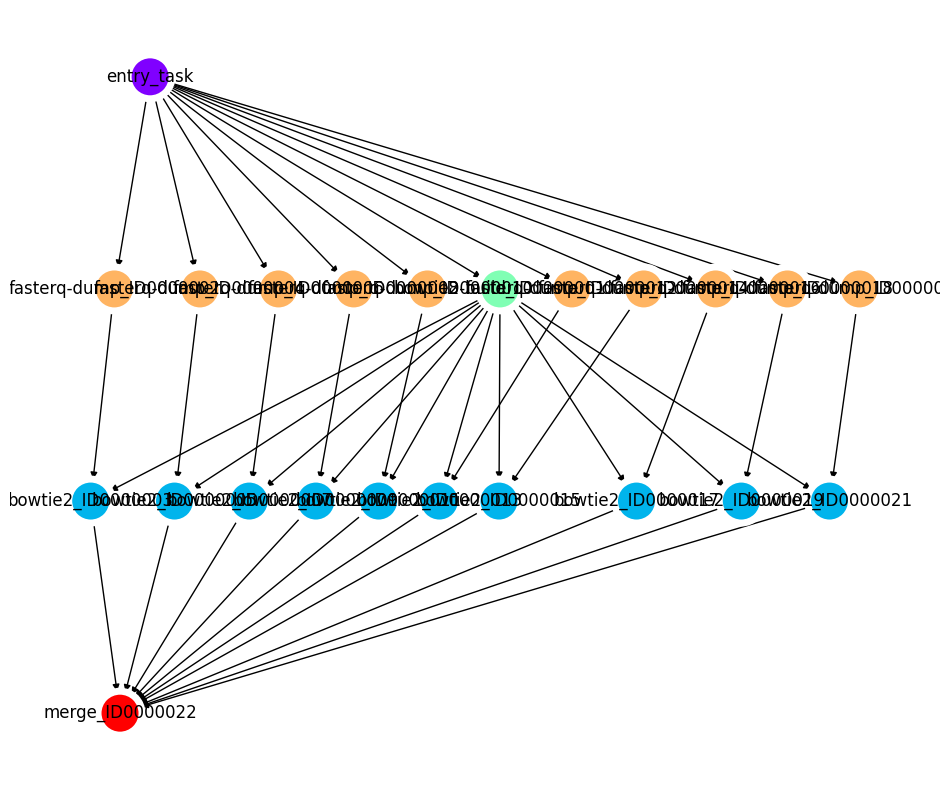

In [12]:
draw(workflow_genome.wf_instance.workflow, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

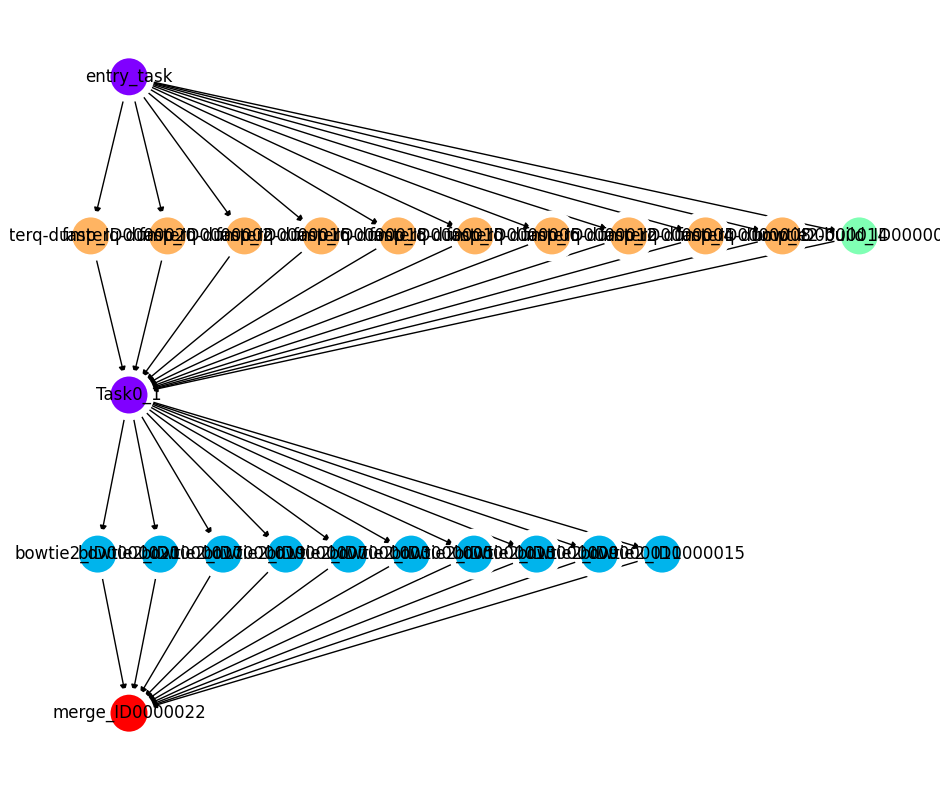

In [13]:
subworkflows, deadlines = HeftBasedAlgorithm().decompose(workflow_genome, 2)
wf_workflow1, wf_workflow2 = subworkflows
deadline1, deadline2 = round(deadlines[0]), round(deadlines[1])
merged = merge_subworkflows(subworkflows)
utils.draw(merged, with_labels=True)

In [14]:
print(deadline1)
print(deadline2)

4611
389


In [15]:
workflow1 = wfworkflow_to_qhyper_workflow(wf_workflow1, machines_file, deadline1)
workflow2 = wfworkflow_to_qhyper_workflow(wf_workflow2, machines_file, deadline2)
wsp1 = WorkflowSchedulingOneHot(workflow1)
wsp2 = WorkflowSchedulingOneHot(workflow2)

In [16]:
gurobi1 = Gurobi(problem=wsp1)
gurobi2 = Gurobi(problem=wsp2)

solution_gurobi1 = gurobi1.solve(params_inits={"name": "wsp1"})
solution_gurobi2 = gurobi2.solve(params_inits={"name": "wsp2"})

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)
CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 24 rows, 65 columns and 120 nonzeros
Model fingerprint: 0x9c6ea067
Variable types: 0 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+06]
  Objective range  [2e+01, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 209611.41938
Presolve removed 24 rows and 65 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 209575 209611 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.095750033650e+05, best bound 2.095750033650e+05, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0

In [17]:
solution1 = wsp1.decode_solution(solution_gurobi1)
solution2 = wsp2.decode_solution(solution_gurobi2)

print(f"Task assignment for first subgraph: {solution1}")
print(f"Task assignment for second subgraph: {solution2}")

Task assignment for first subgraph: {'fasterq-dump_ID0000020': 'AresGpu', 'entry_task': 'AresCpu', 'fasterq-dump_ID0000002': 'AresGpu', 'fasterq-dump_ID0000016': 'AresGpu', 'fasterq-dump_ID0000018': 'AresGpu', 'fasterq-dump_ID0000010': 'AresGpu', 'fasterq-dump_ID0000006': 'AresGpu', 'fasterq-dump_ID0000012': 'AresGpu', 'fasterq-dump_ID0000004': 'AresGpu', 'fasterq-dump_ID0000008': 'AresGpu', 'fasterq-dump_ID0000014': 'AresGpu', 'bowtie2-build_ID0000001': 'AresCpu', 'Task0_1': 'AresCpu'}
Task assignment for second subgraph: {'bowtie2_ID0000021': 'AresGpu', 'bowtie2_ID0000017': 'AresGpu', 'bowtie2_ID0000019': 'AresGpu', 'bowtie2_ID0000007': 'AresGpu', 'bowtie2_ID0000003': 'AresGpu', 'bowtie2_ID0000005': 'AresGpu', 'bowtie2_ID0000013': 'AresGpu', 'bowtie2_ID0000009': 'AresGpu', 'bowtie2_ID0000011': 'AresGpu', 'bowtie2_ID0000015': 'AresGpu', 'merge_ID0000022': 'AresCpu', 'Task0_1': 'AresCpu'}


In [18]:
cost1 = wsp1.calculate_solution_cost(solution1)
time1 = wsp1.calculate_solution_timespan(solution1)
print(f"Cost of running first subworkflow: {cost1}")
print(f"Time of running first subworkflow: {time1}")

cost2 = wsp2.calculate_solution_cost(solution2)
time2 = wsp2.calculate_solution_timespan(solution2)
print(f"Cost of running second subworkflow: {cost2}")
print(f"Time of running second subworkflow: {time2}")

print(f"Cost of running full workflow: {cost1 + cost2}")
print(f"Time of running full workflow: {time1 + time2}")

Cost of running first subworkflow: 209575.00336500004
Time of running first subworkflow: 3520.9792800000005
Cost of running second subworkflow: 17692.280697000002
Time of running second subworkflow: 366.923466
Cost of running full workflow: 227267.28406200005
Time of running full workflow: 3887.9027460000007
